# Sentiment Classification Project

In [1]:
import importlib
import sys
from nltk import PorterStemmer
from wordcloud import WordCloud
from textblob import TextBlob

sys.path.append("..")  # Ensure the parent directory is in the path

# --- Local Application/Module Imports ---
import data_loader.data_loader
import data_preprocessing.data_preprocessing
import visualizations.visualizations
import utils.utils

importlib.reload(data_loader.data_loader)
from data_loader.data_loader import *

importlib.reload(data_preprocessing.data_preprocessing)
from data_preprocessing.data_preprocessing import *

importlib.reload(visualizations.visualizations)
from visualizations.visualizations import *

importlib.reload(utils.utils)
from utils.utils import *

# --- Notebook Configuration ---
%matplotlib inline
%config InlineBackend.figure_format='retina'

# --- Global Settings ---
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tnorlha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tnorlha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/tnorlha/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tnorlha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tnorlha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tnorlha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/tnorlha/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tnorlha/nltk_data...
[nltk_data]   Package wordnet is alre

In [2]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /Users/tnorlha/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tnorlha/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tnorlha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/tnorlha/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/tnorlha/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/tnorlha/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


# Load data

In [3]:
train_df, val_df, test_df = load_and_split_data()

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

Train size: 81677
Validation size: 10210
Test size: 10210


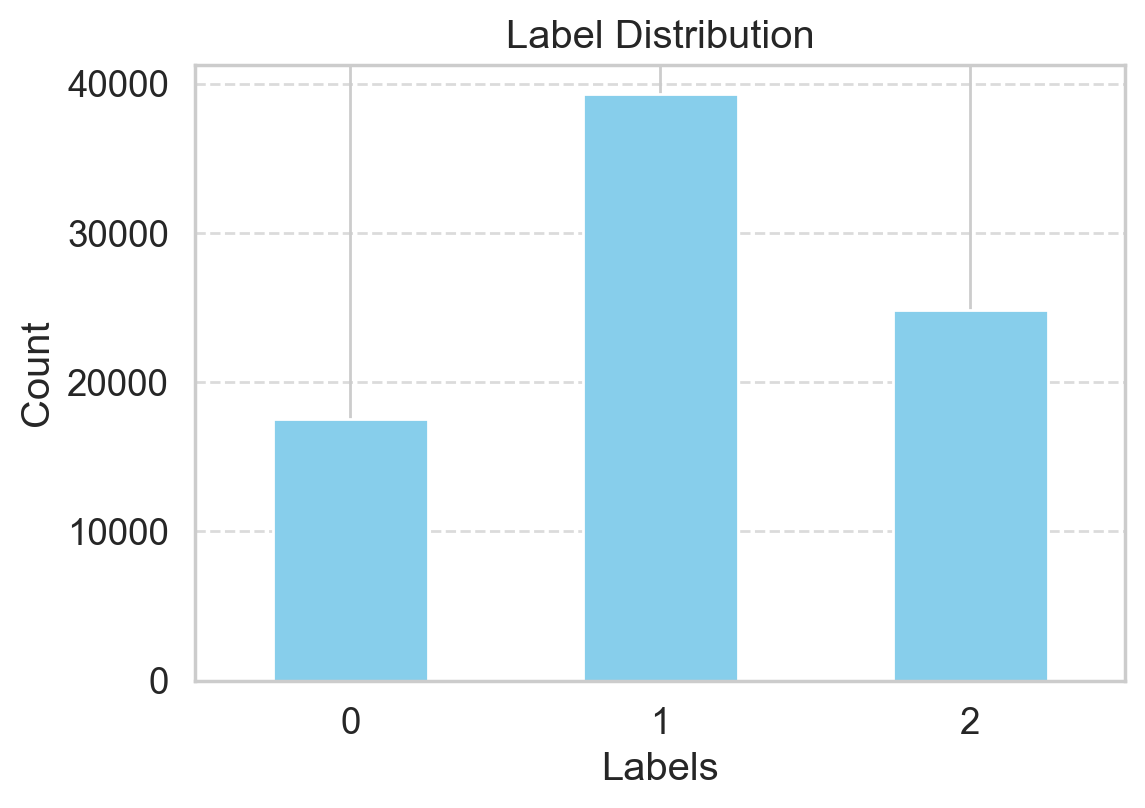

labels
0    17528
1    39318
2    24831
Name: count, dtype: int64

Class distribution (percent):
labels
0    21.46
1    48.14
2    30.40
Name: count, dtype: float64


In [4]:
plot_label_distribution(train_df)

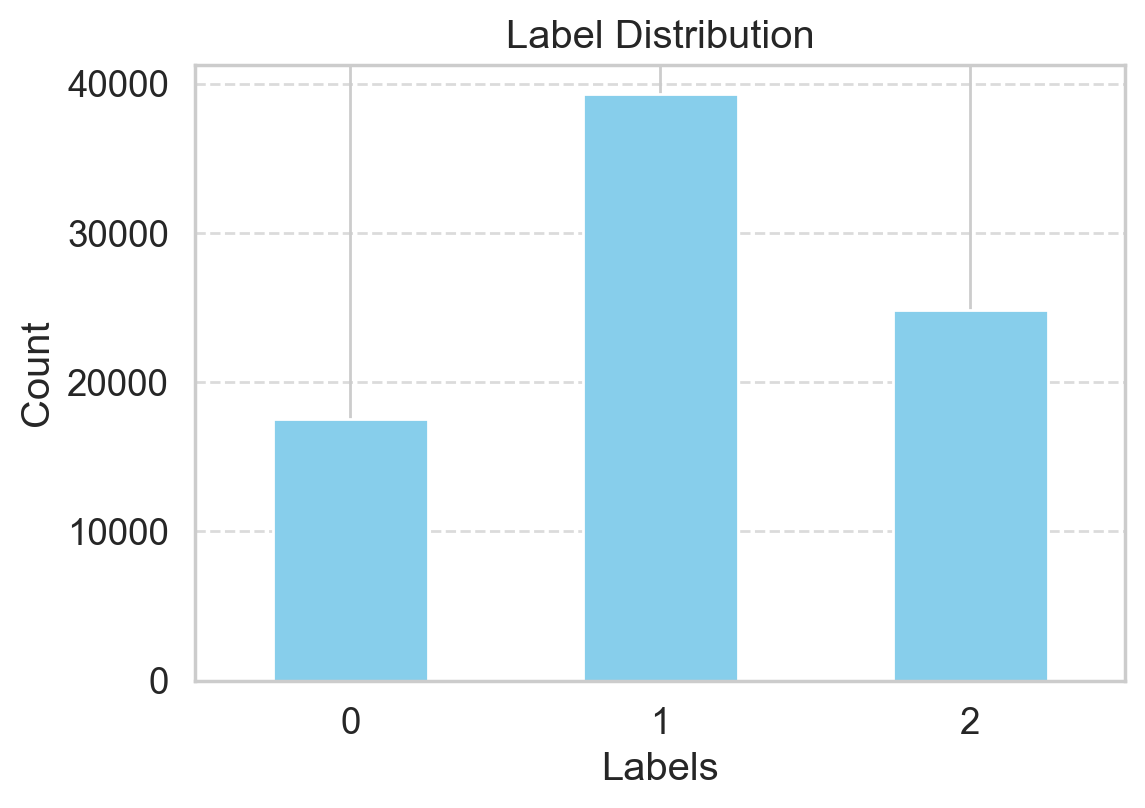

labels
0    17528
1    39318
2    24831
Name: count, dtype: int64

Class distribution (percent):
labels
0    21.46
1    48.14
2    30.40
Name: count, dtype: float64


In [5]:
plot_label_distribution(train_df)

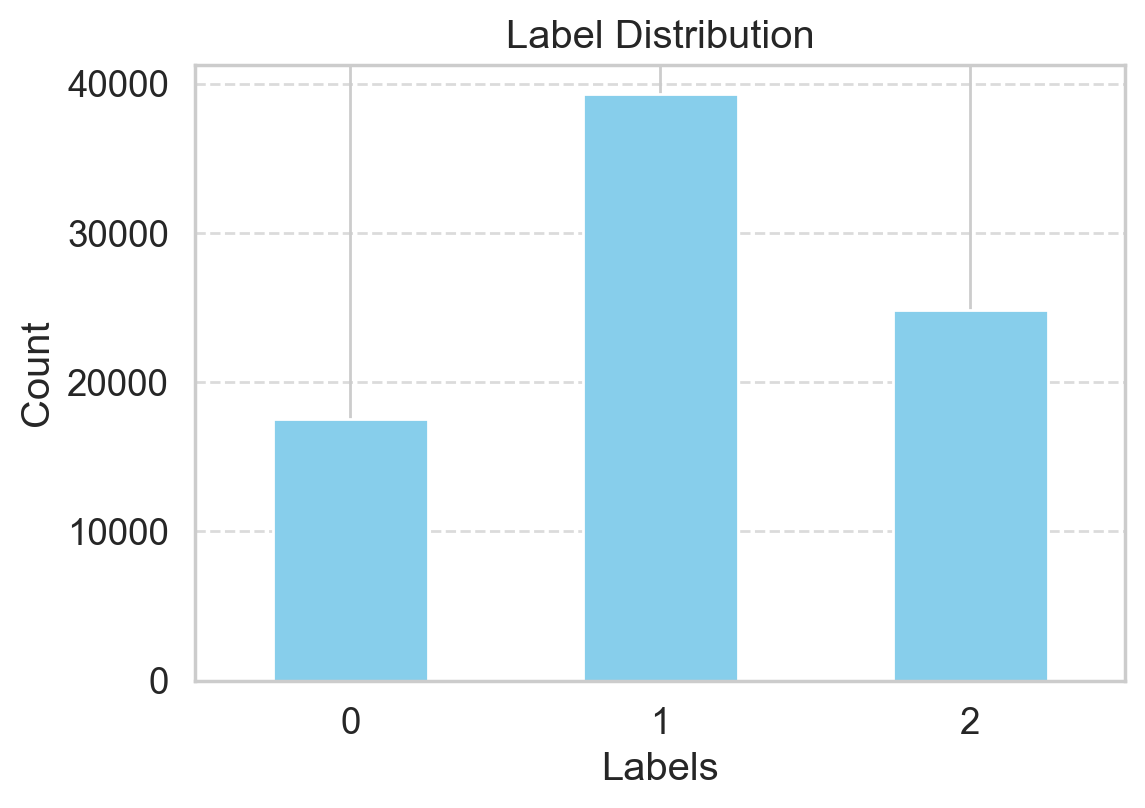

labels
0    17528
1    39318
2    24831
Name: count, dtype: int64

Class distribution (percent):
labels
0    21.46
1    48.14
2    30.40
Name: count, dtype: float64


In [6]:
plot_label_distribution(train_df)

# Better Preprocessing

# NLP approach

- Adding a few columns for more analysis of the dataset

In [7]:
train_analysis = nlp_analysis(train_df)

In [8]:
print(f"Max word count: {train_analysis['word_counts'].max()}")
print(f"Min word count: {train_analysis['word_counts'].min()}")
print(f"Average word count: {train_analysis['word_counts'].mean()}")
print(f"Std word count: {train_analysis['word_counts'].std()}")

Max word count: 258
Min word count: 1
Average word count: 13.6827013724794
Std word count: 8.51681162341921


In [9]:
print(f"Max stop words: {train_analysis['stop_words_len'].max()}")

Max stop words: 125


In [10]:
print(f"Max numeric count: {train_analysis['numerics_count'].max()}")

Max numeric count: 12


In [11]:
print(f"Max upper count: {train_analysis['upper_counts'].max()}")

Max upper count: 26


- Doing a few preprocessing steps (read function definition for more information)

In [12]:
train_df = preprocess_ml_pipeline(train_df, ["lowercase", "expand_contractions", "remove_emails", "remove_urls", "remove_digits", "remove_special_chars", "collapse_spaces", "remove_accented_chars", "remove_stopwords", "lemmatize"])
val_df = preprocess_ml_pipeline(val_df, ["lowercase", "expand_contractions", "remove_emails", "remove_urls", "remove_digits", "remove_special_chars", "collapse_spaces", "remove_accented_chars", "remove_stopwords", "lemmatize"])
test_df = preprocess_ml_pipeline(test_df, ["lowercase", "expand_contractions", "remove_emails", "remove_urls", "remove_digits", "remove_special_chars", "collapse_spaces", "remove_accented_chars", "remove_stopwords", "lemmatize"])

# Analysis and Visualization

Word cloud visualization of the dataset

-> show words in varying sizes based on their frequency

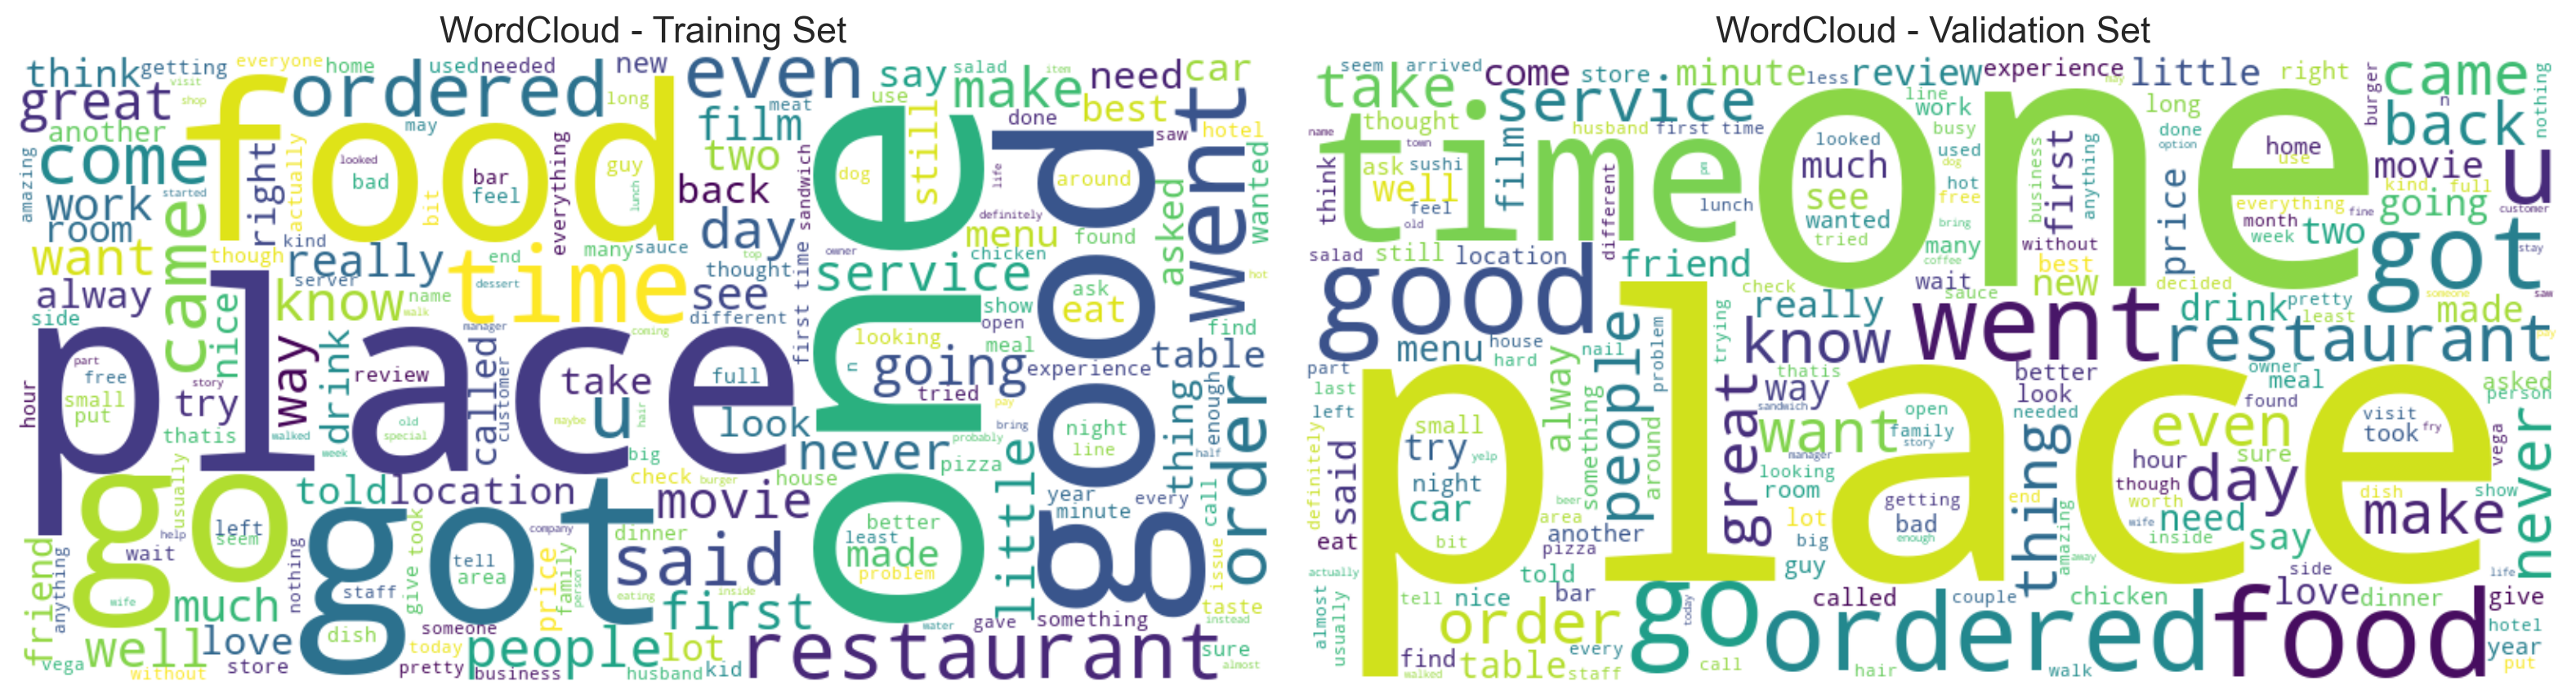

In [13]:
# Combine all sentences into one string for each dataset
text_from_train = ' '.join(train_df['text'])
text_from_valid = ' '.join(val_df['text'])

# Create WordCloud objects
wc_train = WordCloud(width=800, height=400, background_color='white').generate(text_from_train)
wc_valid = WordCloud(width=800, height=400, background_color='white').generate(text_from_valid)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].imshow(wc_train, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('WordCloud - Training Set', fontsize=16)

axes[1].imshow(wc_valid, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('WordCloud - Validation Set', fontsize=16)

plt.tight_layout()
plt.show()

## As a whole

In [14]:
# Lists to store words based on sentiment
negative_words = []
positive_words = []
neutral_words = []

words = text_from_train.split()


# Perform sentiment analysis for each word
for word in words:
    blob = TextBlob(word)

    # blob.sentiment.polarity is a feature provided by TextBlob that quantifies the sentiment of a text.
    # It calculates a numerical value that indicates whether the text is positive, negative, or neutral based on the arrangement of words and their emotional impact.
    sentiment_score = blob.sentiment.polarity
    words = blob.words

    # Categorize words based on sentiment score
    if sentiment_score < 0:
        negative_words.extend(words)
    elif sentiment_score > 0:
        positive_words.extend(words)
    else:
        neutral_words.extend(words)

print('negative_words', len(negative_words))
print('positive_words', len(positive_words))
print('neutral_words', len(neutral_words))

negative_words 24730
positive_words 52780
neutral_words 471455


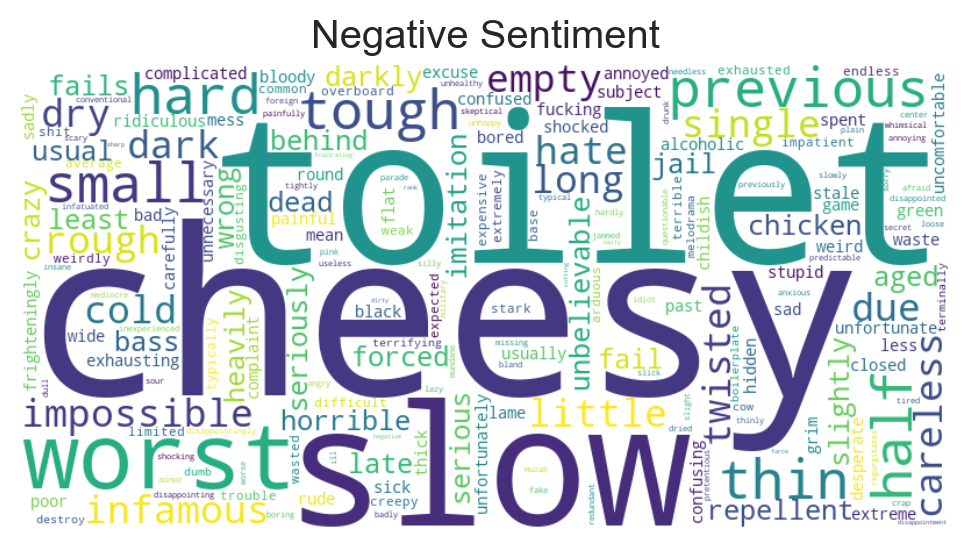

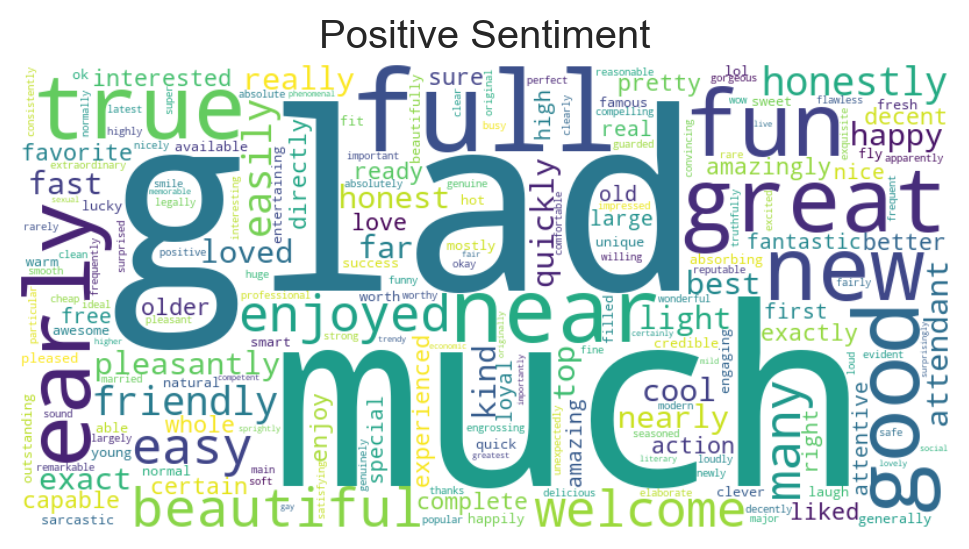

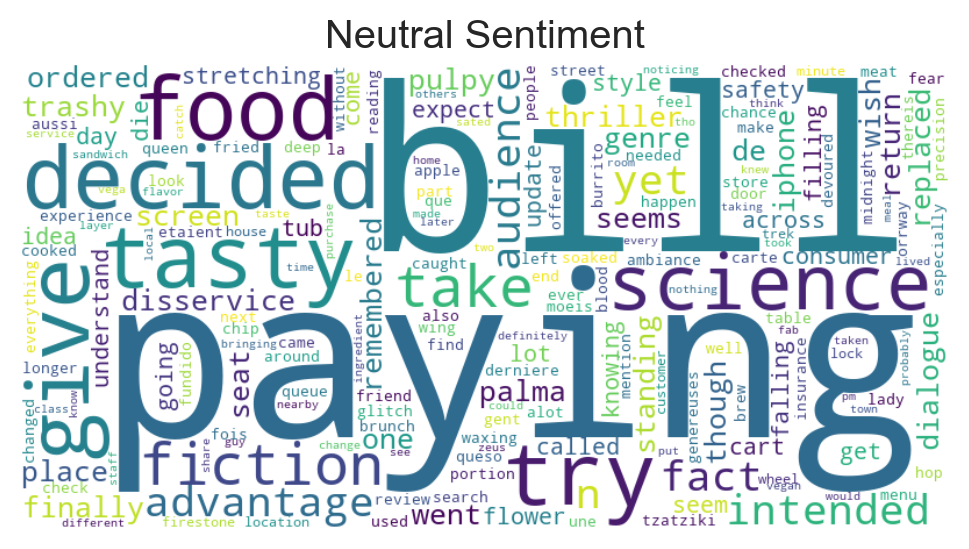

In [15]:
# Generate word cloud for negative words if available
if negative_words:
    negative_wordcloud = WordCloud(width=800, height=400, background_color='white')
    negative_wordcloud.generate_from_frequencies(dict(zip(negative_words, [1] * len(negative_words))))
    plt.figure(figsize=(6, 4))
    plt.imshow(negative_wordcloud, interpolation='bilinear')
    plt.title("Negative Sentiment")
    plt.axis('off')
    plt.show()
else:
    print("No negative words available for word cloud.")

# Generate word cloud for positive words if available
if positive_words:
    positive_wordcloud = WordCloud(width=800, height=400, background_color='white')
    positive_wordcloud.generate_from_frequencies(dict(zip(positive_words, [1] * len(positive_words))))
    plt.figure(figsize=(6, 4))
    plt.imshow(positive_wordcloud, interpolation='bilinear')
    plt.title("Positive Sentiment")
    plt.axis('off')
    plt.show()
else:
    print("No positive words available for word cloud.")

# Generate word cloud for neutral words if available
if neutral_words:
    neutral_wordcloud = WordCloud(width=800, height=400, background_color='white')
    neutral_wordcloud.generate_from_frequencies(dict(zip(neutral_words, [1] * len(neutral_words))))
    plt.figure(figsize=(6, 4))
    plt.imshow(neutral_wordcloud, interpolation='bilinear')
    plt.title("Neutral Sentiment")
    plt.axis('off')
    plt.show()
else:
    print("No neutral words available for word cloud.")

## Samples individually

In [16]:
train_sentiment_df = {}
train_sentiment_df["sentence"] = train_df["text"].copy()

In [17]:
# Performing Stemming
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [18]:
train_sentiment_df["sentence"] = train_sentiment_df["sentence"].apply(lambda x: stemming(x))

In [19]:
#visualizing Processed text
print(train_sentiment_df["sentence"].iloc[0],"\n")
print(train_sentiment_df["sentence"].iloc[1],"\n")

glad paying bill 

decided give try 



In [20]:
train_sentiment_df['scores'] = train_sentiment_df['sentence'].apply(lambda review: sid.polarity_scores(review))

In [21]:
train_sentiment_df['compound']  = train_sentiment_df['scores'].apply(lambda score_dict: score_dict['compound'])

In [22]:
train_sentiment_df['comp_score'] = train_sentiment_df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

In [23]:
#calculating polarity for categorizing text
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [24]:
train_sentiment_df["polarity"] = train_sentiment_df["sentence"].apply(polarity)

In [25]:
train_sentiment_df_list = pd.DataFrame(train_sentiment_df, columns=['sentence','polarity'])

In [26]:
#  Adding Sentiment to the data frame
def sentiment(label):
    if label <0:
        return "negative"
    elif label ==0:
        return "neutral"
    elif label>0:
        return "positive"

In [27]:
train_sentiment_df_list['sentiment'] = train_sentiment_df_list['polarity'].apply(sentiment)
train_sentiment_df_list.head(10)

,sentence,polarity,sentiment
id,,,
93866,glad paying bill,0.500000,positive
49185,decided give try,0.000000,neutral
8401,food tasty,0.000000,neutral
89069,science fiction take advantage fact intended a...,0.200000,positive
51789,went iphone screen replaced,0.000000,neutral
42212,full cheesy dialogue great trashy fun finally ...,0.175000,positive
33833,one seems good true place,0.525000,positive
20066,wish remembered ordered though,0.000000,neutral
33631,standing toilet seat stretching across tub ide...,-0.033333,negative


In [28]:
#Visualizing the Sentiment
fig = plt.figure(figsize=(7,5))
sns.countplot(x="sentiment",data=train_sentiment_df_list)

<Axes: xlabel='sentiment', ylabel='count'>

In [29]:
fig = plt.figure(figsize=(7,7))
colors = ("yellow", "green", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = train_sentiment_df_list['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

Text(0.5, 1.0, 'Distribution of sentiments')

In [30]:
#Visulaizing Top 5 positive Sentiments
pos_samples = train_sentiment_df_list[train_sentiment_df_list.sentiment == 'positive']
pos_samples = pos_samples.sort_values(['polarity'], ascending= False)
pos_samples.head()

,sentence,polarity,sentiment
id,,,
64217,pho perfect hangover cure,1.0,positive
79594,went best buy browse kitchen appliance,1.0,positive
86402,always thought toni guy best anymore,1.0,positive
81639,sushi excellent,1.0,positive
63362,restaurant fifteen time definitely best sushi ...,1.0,positive


Get the sentiment scores

In [31]:
train_sentiment_df_list['scores'] = train_sentiment_df_list['sentence'].apply(lambda review: sid.polarity_scores(review))

train_sentiment_df_list['compound']  = train_sentiment_df_list['scores'].apply(lambda score_dict: score_dict['compound'])

train_sentiment_df_list['comp_score'] = train_sentiment_df_list['compound'].apply(lambda c: 'positive' if c > 0 else ('neutral' if c == 0 else 'negative'))

train_sentiment_df_list.head()

,sentence,polarity,sentiment,scores,compound,comp_score
id,,,,,,
93866,glad paying bill,0.5,positive,"{'neg': 0.0, 'neu': 0.4, 'pos': 0.6, 'compound...",0.4588,positive
49185,decided give try,0.0,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
8401,food tasty,0.0,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
89069,science fiction take advantage fact intended a...,0.2,positive,"{'neg': 0.0, 'neu': 0.857, 'pos': 0.143, 'comp...",0.2500,positive
51789,went iphone screen replaced,0.0,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
